In [30]:
import finesse
import matplotlib.pyplot as plt
finesse.init_plotting()
import numpy as np
from finesse.analysis.actions import Xaxis, Series, Action, RunLocks, RunLocksSolution, Noxaxis
import logging
LOGGER = logging.getLogger(__name__)

In [31]:
def adjust_PRC_length(model, N=3, verbose=False):
    """
    Adjust PRC length so that it fulfils the requirement
    lPRC = (N+1/2) * c/(2*f1), see [1] equation C.1
    In the current design N=3.

    This function directly alters the lengths of the associated kat object.touch
    
    References
    ----------
    1) Charlotte Bond, thesis, https://etheses.bham.ac.uk/id/eprint/5223/
    """
    from finesse.symbols import CONSTANTS
    ltmp = 0.5 * CONSTANTS['c'] / model.f1.value
    delta_l = float((N+0.5) * ltmp - model.lPRC.value)
    if verbose:
        print(f"Adjusting kat.lp1.L by {delta_l:.3}m")
    model.spaces.lp1.L += delta_l

def adjust_SRC_length(model, M=17, verbose=False):
    """
    Adjust SRC length so that it fulfils the requirement
    lSRC = (M/5) * c/(2*f1), see [1] equation C.1
    In the current design M=17 and N=3.4.

    This function directly alters the lengths of the associated kat object.
    
    References
    ----------
    1) Charlotte Bond, thesis, https://etheses.bham.ac.uk/id/eprint/5223/
    """
    from finesse.symbols import CONSTANTS
    ltmp = 0.5 * CONSTANTS['c']  / model.f1.value
    delta_l = float(M/5 * ltmp - model.lSRC.value.eval())
    if verbose:
        print(f"Adusting kat.ls1.L by {delta_l:.4}m")
    model.spaces.ls1.L += delta_l
    
def set_lock_gains(model, d_dof=1e-6, gain_scale=1, verbose=False):
    """For the current state of the model each lock will have its
    gain computed. This is done by computing the gradient of the
    error signal with respect to the set feedback.
    
    The optical gain is then computed as -1/(slope).
    
    This function alters the state of the provided model.
    
    Parameters
    ----------
    model : Model
        Model to set the lock gains of
    d_dof : double
        step size for computing the slope of the error signals
    verbose : boolean
        Prints information when true
    """
    from finesse.analysis.actions import Xaxis, Series
    from finesse.components.readout import ReadoutOutput
    
    for lock in model.locks:
        # Make sure readouts being used have their outputs enabled
        if type(lock.error_signal) is ReadoutOutput:
            lock.error_signal.readout.output_detectors = True
            
    # Use a flattened series analysis as it only creates one model
    # and xaxis resets all the parameters each time
    analysis = Series(*(
            Xaxis(lock.feedback, 'lin', -d_dof, d_dof, 1, relative=True, name=lock.name) for lock in model.locks
        ),
        flatten=True 
    )
    sol = analysis.run(model)
    N = len(model.locks)
    for lock in model.locks:
        lock_sol = sol[lock.name]
        x = lock_sol.x1
        error = lock_sol[lock.error_signal.name] + lock.offset
        lock.gain = -1/np.gradient(error, x[1]-x[0]).mean() * gain_scale
        if verbose:
            print(lock, lock.error_signal.name, lock.gain)
            
def get_lock_error_signals(model, dof_range, steps=1000, verbose=False):
    from finesse.analysis.actions import Xaxis, Series
    from finesse.components.readout import ReadoutOutput
    
    for lock in model.locks:
        # Make sure readouts being used have their outputs enabled
        if type(lock.error_signal) is ReadoutOutput:
            lock.error_signal.readout.output_detectors = True
            
    # Use a flattened series analysis as it only creates one model
    # and xaxis resets all the parameters each time
    analysis = Series(*(
            Xaxis(lock.feedback, 'lin', -dof_range, dof_range, steps, relative=True, name=lock.feedback.owner.name) for lock in model.locks
        ),
        flatten=True 
    )
    sol = analysis.run(model)
    return sol

In [34]:
base = finesse.Model()
base.parse("""
# modulators for core interferometer sensing - Advanced LIGO, CQG, 2015
# http://iopscience.iop.org/article/10.1088/0264-9381/32/7/074001/meta#cqg507871s4-8
# 9MHz (CARM, PRC, SRC loops)
variable f1 9099471
variable f2 45497355
variable nsilica 1.45
variable Mloss 30u
variable Larm 3994
###########################################################################
###   laser
###########################################################################
# Laser and input optics
laser L0 P=125
mod mod1 f=&f1 midx=0.18 order=1 mod_type=pm
mod mod2 f=&f2 midx=0.18 order=1 mod_type=pm
link(L0, mod1, mod2)
###########################################################################
###   PRC
###########################################################################
s sPRCin mod2.p2 PRMAR.p1
m PRMAR R=0 L=40u xbeta=&PRM.xbeta ybeta=&PRM.ybeta phi=&PRM.phi
s sPRMsub1 PRMAR.p2 PRM.p1 L=0.0737 nr=&nsilica
m PRM T=0.03 L=8.5u Rc=11.009
s lp1 PRM.p2 PR2.p1 L=16.6107
bs PR2 T=250u L=&Mloss alpha=-0.79 Rc=-4.545
s lp2 PR2.p2 PR3.p1 L=16.1647
bs PR3 T=0 L=&Mloss alpha=0.615 Rc=36.027
s lp3 PR3.p2 BS.p1 L=19.5381
###########################################################################
###   BS
###########################################################################
bs BS R=0.5 L=&Mloss alpha=45
s BSsub1 BS.p3 BSAR1.p1 L=0.0687 nr=&nsilica
s BSsub2 BS.p4 BSAR2.p2 L=0.0687 nr=&nsilica
bs BSAR1 L=50u R=0 alpha=-29.195
bs BSAR2 L=50u R=0 alpha=29.195
###########################################################################
###   Yarm
###########################################################################
# Distance from beam splitter to Y arm input mirror
s ly1 BS.p2 ITMYlens.p1 L=5.0126
lens ITMYlens f=34500
s ly2 ITMYlens.p2 ITMYAR.p1
m ITMYAR R=0 L=20u xbeta=&ITMY.xbeta ybeta=&ITMY.ybeta phi=&ITMY.phi
s ITMYsub ITMYAR.p2 ITMY.p1 L=0.2 nr=&nsilica
m ITMY T=0.014 L=&Mloss Rc=-1934
s LY ITMY.p2 ETMY.p1 L=&Larm
m ETMY T=5u L=&Mloss Rc=2245
s ETMYsub ETMY.p2 ETMYAR.p1 L=0.2 nr=&nsilica
m ETMYAR 0 500u xbeta=&ETMY.xbeta ybeta=&ETMY.ybeta phi=&ETMY.phi
###########################################################################
###   Xarm
###########################################################################
# Distance from beam splitter to X arm input mirror
s lx1 BSAR1.p3 ITMXlens.p1 L=4.993
lens ITMXlens f=34500
s lx2 ITMXlens.p2 ITMXAR.p1
m ITMXAR R=0 L=20u xbeta=&ITMX.xbeta ybeta=&ITMX.ybeta phi=&ITMX.phi
s ITMXsub ITMXAR.p2 ITMX.p1 L=0.2 nr=&nsilica
m ITMX T=0.014 L=&Mloss Rc=-1934
s LX ITMX.p2 ETMX.p1 L=&Larm
m ETMX T=5u L=&Mloss Rc=2245
s ETMXsub ETMX.p2 ETMXAR.p1 L=0.2 nr=&nsilica
m ETMXAR 0 500u xbeta=&ETMX.xbeta ybeta=&ETMX.ybeta phi=&ETMX.phi
###########################################################################
###   SRC
###########################################################################
s ls3 BSAR2.p4 SR3.p1 L=19.3661
bs SR3 T=0 L=&Mloss alpha=0.785 Rc=35.972841
s ls2 SR3.p2 SR2.p1 L=15.4435
bs SR2 T=0 L=&Mloss alpha=-0.87 Rc=-6.406
s ls1 SR2.p2 SRM.p1 L=15.7586
m SRM T=0.20 L=8.7u Rc=-5.6938
s SRMsub SRM.p2 SRMAR.p1 L=0.0749 nr=&nsilica
m SRMAR R=0 L=50n
###########################################################################
###   OMC
###########################################################################
# Here we just use some simple filter to approximate an OMC for filtering
# out RF fields, this doesn't filter HOMs!
obp OMC fc=0 bandwidth=1M
link(SRMAR.p2, OMC)
###########################################################################
### Helpful Equations
###########################################################################
variable lprc value=(&lp1.L + &lp2.L + &lp3.L)
variable lx value=(&lx1.L + &BSsub1.L * &BSsub1.nr + &ITMXsub.L * &ITMXsub.nr)
variable ly value=(&ly1.L + &ITMYsub.L * &ITMYsub.nr)
variable lsrc value=(&ls1.L + &ls2.L + &ls3.L + &BSsub2.L * &BSsub2.nr)
variable lMI value=(0.5 * (&lx + &ly))
variable lPRC value=(&lprc + &lMI)
variable lSRC value=(&lsrc + &lMI)
variable lSchnupp value=(&lx - &ly)
###########################################################################
### Sensing and Control
###########################################################################
dof CARM ETMX.dofs.z +1 ETMY.dofs.z +1
dof DARM ETMX.dofs.z +1 ETMY.dofs.z -1
dof PRCL PRM.dofs.z +1 
dof SRCL SRM.dofs.z +1 DC=90
dof MICH BS.dofs.z +1

readout_rf REFL9 PRMAR.p1.o f=&f1 phase=5
readout_rf POP9  PR2.p3.o   f=&f1 phase=10
readout_rf POP45 PR2.p3.o   f=&f2 phase=0 
readout_rf AS45  SRMAR.p2.o f=&f2 phase=-5
readout_dc AS    OMC.p2.o

lock CARM_lock REFL9.outputs.I CARM.DC -0.1 1e-6 
lock MICH_lock POP45.outputs.Q MICH.DC -15 1e-6
lock PRCL_lock POP9.outputs.I PRCL.DC 2.8 1e-6   
lock SRCL_lock POP45.outputs.I SRCL.DC 42 1e-6 
lock DARM_dc_lock AS.outputs.DC DARM.DC -0.003 1e-6 offset=20m disabled=true # lock to 20mW
lock DARM_rf_lock AS45.outputs.I DARM.DC -0.003 1e-6 disabled=false
###########################################################################
pd Px ETMX.p1.i
pd Py ETMX.p1.i
pd Pp PRM.p2.o
pd Ps SRM.p1.i
ad Aas AS.p1.i f=0
###########################################################################
#cav cav_xarm ETMX.p1.o
#cav cav_yarm ETMY.p1.o
#modes(maxtem=2)
""")
adjust_PRC_length(base, verbose=True)
adjust_SRC_length(base, verbose=True)
set_lock_gains(base, verbose=True)

Adjusting kat.lp1.L by -0.00036m
Adusting kat.ls1.L by -0.001982m
Lock('SRCL_lock') POP45_I 42.3933518637208
Lock('MICH_lock') POP45_Q -15.175878728991153
Lock('DARM_dc_lock') AS_DC -inf
Lock('DARM_rf_lock') AS45_I -0.0033564774286444225
Lock('PRCL_lock') POP9_I 2.8031409912259977
Lock('CARM_lock') REFL9_I -9.882919597609178e-05


<ipython-input-31-4b8c73b8f0ca>:78: RuntimeWarning: divide by zero encountered in double_scalars
  lock.gain = -1/np.gradient(error, x[1]-x[0]).mean() * gain_scale


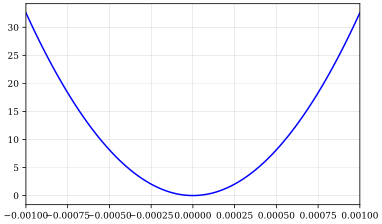

In [35]:
sol = Xaxis("DARM.DC", 'lin', -1e-3, 1e-3, 100, relative=True).run(base)
plt.plot(sol.x1, sol['AS_DC']/1e-3)

In [36]:
# plt.plot(get_lock_error_signals(base, 30)['SRCL']['POP45_I'], c='r')
# plt.plot(get_lock_error_signals(base, 30)['SRCL']['POP45_Q'], c='b')
# plt.plot(get_lock_error_signals(base, 30)['MICH']['POP45_I'], c='r', ls='--')
# plt.plot(get_lock_error_signals(base, 30)['MICH']['POP45_Q'], c='b', ls='--')

# sol = get_lock_error_signals(base, 1)
# plt.plot(sol['CARM']['REFL9_I'], c='r', label='I')
# plt.plot(sol['CARM']['REFL9_Q'], c='b', label='Q')
# plt.legend()

# sol = get_lock_error_signals(base, 1)
# plt.plot(get_lock_error_signals(base, 1)['DARM']['AS45_I'], c='r', label='I')
# plt.plot(get_lock_error_signals(base, 1)['DARM']['AS45_Q'], c='b', label='Q')
# plt.legend()

# sol = get_lock_error_signals(base, 1)
# plt.plot(get_lock_error_signals(base, 1)['DARM']['AS_DC'], c='r', label='DC')
# plt.legend()

# sol = get_lock_error_signals(base, 10)
# plt.plot(sol['PRCL'].x1, sol['PRCL']['POP9_I'], c='r', ls='--', label='I')
# plt.plot(sol['PRCL'].x1, sol['PRCL']['POP9_Q'], c='b', ls='--', label='Q')
# plt.legend()

In [37]:
aligo = base.deepcopy()
set_lock_gains(aligo, gain_scale=1)
aligo.CARM.DC = 0
aligo.PRCL.DC = 0
aligo.SRCL.DC = 90
aligo.MICH.DC = 0
aligo.DARM.DC = 0.1
sol = RunLocks(exception_on_fail=False, max_iterations=1000).run(aligo)
aligo.CARM.DC, aligo.PRCL.DC, aligo.SRCL.DC, aligo.MICH.DC, sol.iters

<ipython-input-31-4b8c73b8f0ca>:78: RuntimeWarning: divide by zero encountered in double_scalars
  lock.gain = -1/np.gradient(error, x[1]-x[0]).mean() * gain_scale


(<CARM.DC=2.098590644072798e-09 @ 0x7f91232ee300>,
 <PRCL.DC=-1.7686017316343471e-06 @ 0x7f91232e3880>,
 <SRCL.DC=90.00001459211336 @ 0x7f91232e30f0>,
 <MICH.DC=-5.263382520216684e-06 @ 0x7f91232ee880>,
 18)

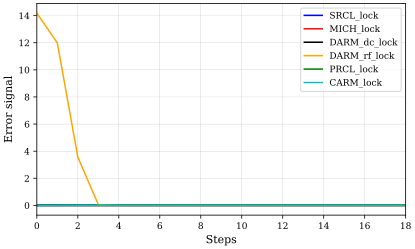

In [38]:
plt.plot(sol.results[:, 0, :(sol.iters+1)].T)
plt.legend(sol.lock_names, loc='upper right')
plt.xlabel("Steps")
plt.ylabel("Error signal")
plt.tight_layout()

In [44]:
from finesse.analysis import Action

class DARM_RF_to_DC(Action):
    """Locks a model using DARM RF readout then transitions the model into
    using a DC readout and locks.
    """
    def __init__(self, name="DarmRF2DC"):
        super().__init__(name)
        self.__lock_rf = RunLocks('DARM_rf_lock')
        self.__lock_dc = RunLocks('DARM_dc_lock')
        
    def _do(self, state):
        assert(not state.model.DARM_rf_lock.disabled)
        assert(state.model.DARM_dc_lock.disabled)
        
        self.__lock_rf._do(state)
        state.model.DARM_rf_lock.disabled = True
        # kick lock away from zero tuning for DC lock to grab with
        state.model.DARM.DC += 0.5e-3 
        # take a guess at the gain
        state.model.DARM_dc_lock.gain = -0.01 
        state.model.DARM_dc_lock.disabled = False
        self.__lock_dc._do(state)
        return None
        
    def _requests(self, model, memo, first=True):
        self.__lock_rf._requests(model, memo)
        self.__lock_dc._requests(model, memo)
        return memo
    
aligo = base.deepcopy()
aligo.DARM.DC = 0.1
print("Before", aligo.DARM.DC, aligo.CARM.DC, aligo.PRCL.DC, aligo.SRCL.DC, aligo.MICH.DC)
DARM_RF_to_DC().run(aligo)
print("After", aligo.DARM.DC, aligo.CARM.DC, aligo.PRCL.DC, aligo.SRCL.DC, aligo.MICH.DC)

Before 0.1 0.0 0.0 90.0 0.0
After 0.0007834026875408984 0.0 0.0 90.0 0.0
